<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [126]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [127]:
import sys
sys.path.append('/content/torch_helpers.py')

In [128]:
from urllib import request

# URL The Project Gutenberg eBook of The Time Machine, by H. G. Wells
url = "https://www.gutenberg.org/files/35/35-0.txt"

# Variable para almacenar el libro
texts = []

# Recuperar el contenido del libro
response = request.urlopen(url)
raw = response.read()
text = raw.decode("utf-8-sig")

In [129]:
# Separo el texto en oraciones, las cuales se separan mediante un punto ('.')
sentences = text.split('.')

# Creo un dataframe que contiene las oraciones
df = pd.DataFrame({'Oracion': sentences})

df.head()

,Oracion
0,The Project Gutenberg eBook of The Time Machin...
1,G
2,Wells\r\n\r\nThis eBook is for the use of any...
3,"You may copy it, give it away or re-use it un..."
4,gutenberg


In [130]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2031


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [131]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [132]:
import re

# Preprocesamiento: filtro números, espacios en blanco consecutivos y caractéres especiales
book = [re.sub(r'[^a-zA-z.!?/\"\'\s]', ' ', sentence) for sentence in df['Oracion']]
book = [re.sub(r'\s+', ' ', sentence) for sentence in book]
book = [re.sub(r'[\_\[\]]', '',sentence) for sentence in book]
book = [sentence.lower() for sentence in book]

In [133]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
# Entran oraciones y salen vectores de N posiciones (tokens)
sentence_tokens = [text_to_word_sequence(sentence) for sentence in book]
# Analizo como tokeniza la oración numero 2000
sentence_tokens[2000]

['email',
 'contact',
 'links',
 'and',
 'up',
 'to',
 'date',
 'contact',
 'information',
 'can',
 'be',
 'found',
 'at',
 'the',
 "foundation's",
 'website',
 'and',
 'official',
 'page',
 'at',
 'www']

In [134]:
# Largo de la secuencia: incluye seq input + word output
train_len = 4

# Desfasaje de palabras según el train_len
text_sequences = []

for sentence in sentence_tokens:
    if len(sentence) >= train_len:
        for i in range(train_len, len(sentence) + 1):
            seq = sentence[i - train_len : i]
            text_sequences.append(seq)

print(f'Cantidad de secuencias: {len(text_sequences)}')

Cantidad de secuencias: 30263


In [135]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[1500:2000]

[['see', 'your', 'experiment', 'anyhow'],
 ['your', 'experiment', 'anyhow', 'said'],
 ['experiment', 'anyhow', 'said', 'the'],
 ['anyhow', 'said', 'the', 'psychologist'],
 ['said', 'the', 'psychologist', 'though'],
 ['the', 'psychologist', 'though', 'it'],
 ['psychologist', 'though', 'it', 's'],
 ['though', 'it', 's', 'all'],
 ['it', 's', 'all', 'humbug'],
 ['s', 'all', 'humbug', 'you'],
 ['all', 'humbug', 'you', 'know'],
 ['the', 'time', 'traveller', 'smiled'],
 ['time', 'traveller', 'smiled', 'round'],
 ['traveller', 'smiled', 'round', 'at'],
 ['smiled', 'round', 'at', 'us'],
 ['then', 'still', 'smiling', 'faintly'],
 ['still', 'smiling', 'faintly', 'and'],
 ['smiling', 'faintly', 'and', 'with'],
 ['faintly', 'and', 'with', 'his'],
 ['and', 'with', 'his', 'hands'],
 ['with', 'his', 'hands', 'deep'],
 ['his', 'hands', 'deep', 'in'],
 ['hands', 'deep', 'in', 'his'],
 ['deep', 'in', 'his', 'trousers'],
 ['in', 'his', 'trousers', 'pockets'],
 ['his', 'trousers', 'pockets', 'he'],
 ['trou

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [136]:
tok = Tokenizer()
# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences)

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = np.array(tok.texts_to_sequences(text_sequences))

In [137]:
# Ahora sequences tiene los números "ID", largo 4
sequences

array([[   1,   44,   45,  321],
       [  44,   45,  321,    2],
       [  45,  321,    2,    1],
       ...,
       [4196,    6,  573,   57],
       [   6,  573,   57,  169],
       [ 573,   57,  169,  596]])

In [138]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

30263


In [139]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

4939


In [140]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'of': 2, 'and': 3, 'i': 4, 'a': 5, 'to': 6, 'in': 7, 'was': 8, 'that': 9, 'my': 10, 'it': 11, 'had': 12, 'as': 13, 'with': 14, 'me': 15, 'for': 16, 'at': 17, 'time': 18, 'this': 19, 'you': 20, 'or': 21, 'but': 22, 'on': 23, 'were': 24, 'from': 25, 'not': 26, 'have': 27, 'by': 28, 'all': 29, 'his': 30, 'is': 31, 'into': 32, 'be': 33, 'upon': 34, 'little': 35, 'one': 36, 'they': 37, 'came': 38, 'which': 39, 'there': 40, 'so': 41, 'no': 42, 'some': 43, 'project': 44, 'gutenberg': 45, 'he': 46, 'an': 47, 'their': 48, 'could': 49, 'saw': 50, 'down': 51, 'machine': 52, 'then': 53, 'any': 54, 'we': 55, 'them': 56, 'about': 57, 'up': 58, 'very': 59, 'out': 60, 'what': 61, 'said': 62, 'been': 63, 'like': 64, 'these': 65, 'now': 66, 'her': 67, 'its': 68, 'seemed': 69, 'are': 70, 's': 71, 'man': 72, 'would': 73, 'white': 74, 'thing': 75, 'again': 76, 'must': 77, 'more': 78, 'if': 79, 'tm': 80, 'traveller': 81, 'when': 82, 'our': 83, 'over': 84, 'work': 85, 'other': 86, 'thought': 87, '

In [141]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'project': 325, 'gutenberg': 323, 'ebook': 45, 'the': 8106, 'of': 4694, 'time': 682, 'machine': 296, 'by': 457, 'h': 3, 'this': 648, 'wells': 33, 'is': 421, 'for': 827, 'use': 77, 'anyone': 25, 'anywhere': 11, 'in': 2155, 'united': 56, 'states': 62, 'and': 4641, 'most': 117, 'other': 180, 'parts': 20, 'world': 127, 'at': 791, 'no': 322, 'cost': 12, 'with': 947, 'almost': 97, 'restrictions': 4, 'whatsoever': 2, 'may': 152, 'you': 626, 'copy': 45, 'it': 1308, 'give': 30, 'away': 127, 'or': 589, 're': 12, 'under': 143, 'terms': 92, 'license': 61, 'included': 9, 'online': 13, 'www': 10, 'if': 203, 'are': 234, 'not': 492, 'located': 28, 'will': 160, 'have': 462, 'to': 2761, 'check': 14, 'laws': 29, 'country': 28, 'where': 123, 'before': 174, 'using': 22, 'title': 1, 'author': 2, 'release': 2, 'july': 4, 'date': 23, 'recently': 4, 'updated': 6, 'october': 4, 'language': 21, 'english': 12, 'character': 13, 'set': 85, 'encoding': 4, 'utf': 4, 'start': 20, 'an': 322,

In [142]:
total_words = len(tok.index_word)+1

### 3 - Input y target

In [143]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [144]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [145]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [146]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(30263, 3)
(30263,)


In [147]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'of',
 3: 'and',
 4: 'i',
 5: 'a',
 6: 'to',
 7: 'in',
 8: 'was',
 9: 'that',
 10: 'my',
 11: 'it',
 12: 'had',
 13: 'as',
 14: 'with',
 15: 'me',
 16: 'for',
 17: 'at',
 18: 'time',
 19: 'this',
 20: 'you',
 21: 'or',
 22: 'but',
 23: 'on',
 24: 'were',
 25: 'from',
 26: 'not',
 27: 'have',
 28: 'by',
 29: 'all',
 30: 'his',
 31: 'is',
 32: 'into',
 33: 'be',
 34: 'upon',
 35: 'little',
 36: 'one',
 37: 'they',
 38: 'came',
 39: 'which',
 40: 'there',
 41: 'so',
 42: 'no',
 43: 'some',
 44: 'project',
 45: 'gutenberg',
 46: 'he',
 47: 'an',
 48: 'their',
 49: 'could',
 50: 'saw',
 51: 'down',
 52: 'machine',
 53: 'then',
 54: 'any',
 55: 'we',
 56: 'them',
 57: 'about',
 58: 'up',
 59: 'very',
 60: 'out',
 61: 'what',
 62: 'said',
 63: 'been',
 64: 'like',
 65: 'these',
 66: 'now',
 67: 'her',
 68: 'its',
 69: 'seemed',
 70: 'are',
 71: 's',
 72: 'man',
 73: 'would',
 74: 'white',
 75: 'thing',
 76: 'again',
 77: 'must',
 78: 'more',
 79: 'if',
 80: 'tm',
 81: 'travelle

In [148]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4939

In [149]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [150]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [151]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)
y_data.shape

(30263, 4939)

In [152]:
X = sequences[:, :-1] # todos los rows, menos la ultima col
y = sequences[:, -1] # última col de cada row

print(f'\nTamaño de entrada: {X.shape}')
print(f'Tamaño de salida: {y.shape}')


Tamaño de entrada: (30263, 3)
Tamaño de salida: (30263,)


In [153]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder
y = to_categorical(y-1, num_classes = total_words)

print(x_data.shape)
print(y_data_int.shape)

(30263, 3)
(30263,)


In [154]:
y.shape

(30263, 4940)

### 4 - Entrenar el modelo

In [155]:
# largo de la secuencia de entrada
input_seq_len = X.shape[1]
# Largo del vector de salida
output_size = total_words

In [156]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

4939

In [157]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim = total_words, output_dim = 5, input_length = input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 3, 5)              24700     
                                                                 
 lstm_12 (LSTM)              (None, 3, 64)             17920     
                                                                 
 dropout_8 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 4939)              162987    
                                                                 
Total params: 240,711
Trainable params: 240,711
Non-tr

In [158]:
model2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model2.add(Embedding(input_dim = total_words, output_dim = 5, input_length = input_seq_len))

model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128)) # La última capa LSTM no lleva return_sequences
model2.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model2.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 3, 5)              24700     
                                                                 
 lstm_14 (LSTM)              (None, 3, 128)            68608     
                                                                 
 dropout_9 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_15 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_10 (Dropout)        (None, 3, 128)            0         
                                                                 
 lstm_16 (LSTM)              (None, 3, 128)            131584    
                                                                 
 dropout_11 (Dropout)        (None, 3, 128)           

In [171]:
model3 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model3.add(Embedding(input_dim = total_words,
                    output_dim = 5,
                    input_length = input_seq_len))

model3.add(LSTM(64, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(64, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(64, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model3.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model3.add(Dense(output_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 3, 5)              24700     
                                                                 
 lstm_18 (LSTM)              (None, 3, 64)             17920     
                                                                 
 dropout_12 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_19 (LSTM)              (None, 3, 64)             33024     
                                                                 
 dropout_13 (Dropout)        (None, 3, 64)             0         
                                                                 
 lstm_20 (LSTM)              (None, 3, 64)             33024     
                                                                 
 dropout_14 (Dropout)        (None, 3, 64)            

In [159]:
hist = model.fit(x_data, y_data, epochs=10, validation_split=0.2)

Epoch 1/10
757/757 [==============================] - 19s 18ms/step - loss: 6.8213 - accuracy: 0.0652 - val_loss: 7.2344 - val_accuracy: 0.0740
Epoch 2/10
757/757 [==============================] - 10s 13ms/step - loss: 6.3798 - accuracy: 0.0673 - val_loss: 7.3134 - val_accuracy: 0.0740
Epoch 3/10
757/757 [==============================] - 14s 18ms/step - loss: 6.2498 - accuracy: 0.0673 - val_loss: 7.5187 - val_accuracy: 0.0740
Epoch 4/10
757/757 [==============================] - 8s 11ms/step - loss: 6.1314 - accuracy: 0.0785 - val_loss: 7.6062 - val_accuracy: 0.0881
Epoch 5/10
757/757 [==============================] - 10s 13ms/step - loss: 5.9580 - accuracy: 0.0948 - val_loss: 7.6280 - val_accuracy: 0.0933
Epoch 6/10
757/757 [==============================] - 10s 13ms/step - loss: 5.8253 - accuracy: 0.0995 - val_loss: 7.7699 - val_accuracy: 0.0952
Epoch 7/10
757/757 [==============================] - 8s 10ms/step - loss: 5.7137 - accuracy: 0.1025 - val_loss: 8.0734 - val_accuracy: 0

In [168]:
hist2 = model2.fit(x_data, y_data, epochs=10, validation_split=0.2)

Epoch 1/10
757/757 [==============================] - 13s 17ms/step - loss: 5.3213 - accuracy: 0.1145 - val_loss: 8.4292 - val_accuracy: 0.0975
Epoch 2/10
757/757 [==============================] - 12s 16ms/step - loss: 5.2463 - accuracy: 0.1160 - val_loss: 8.5629 - val_accuracy: 0.0925
Epoch 3/10
757/757 [==============================] - 12s 15ms/step - loss: 5.1741 - accuracy: 0.1199 - val_loss: 8.7036 - val_accuracy: 0.0942
Epoch 4/10
757/757 [==============================] - 12s 16ms/step - loss: 5.1049 - accuracy: 0.1202 - val_loss: 8.7885 - val_accuracy: 0.0917
Epoch 5/10
757/757 [==============================] - 14s 18ms/step - loss: 5.0335 - accuracy: 0.1238 - val_loss: 9.0428 - val_accuracy: 0.0927
Epoch 6/10
757/757 [==============================] - 15s 20ms/step - loss: 4.9715 - accuracy: 0.1243 - val_loss: 9.1507 - val_accuracy: 0.0904
Epoch 7/10
757/757 [==============================] - 12s 16ms/step - loss: 4.8988 - accuracy: 0.1254 - val_loss: 9.2748 - val_accuracy:

In [172]:
hist3 = model3.fit(x_data, y_data, epochs=10, validation_split=0.2)

Epoch 1/10
757/757 [==============================] - 26s 23ms/step - loss: 6.8163 - accuracy: 0.0667 - val_loss: 7.2263 - val_accuracy: 0.0740
Epoch 2/10
757/757 [==============================] - 13s 17ms/step - loss: 6.4390 - accuracy: 0.0673 - val_loss: 7.4219 - val_accuracy: 0.0740
Epoch 3/10
757/757 [==============================] - 13s 17ms/step - loss: 6.3948 - accuracy: 0.0673 - val_loss: 7.5861 - val_accuracy: 0.0740
Epoch 4/10
757/757 [==============================] - 14s 18ms/step - loss: 6.3705 - accuracy: 0.0673 - val_loss: 7.8002 - val_accuracy: 0.0740
Epoch 5/10
757/757 [==============================] - 12s 16ms/step - loss: 6.3493 - accuracy: 0.0673 - val_loss: 7.9355 - val_accuracy: 0.0738
Epoch 6/10
757/757 [==============================] - 17s 22ms/step - loss: 6.3018 - accuracy: 0.0673 - val_loss: 7.8140 - val_accuracy: 0.0730
Epoch 7/10
757/757 [==============================] - 13s 17ms/step - loss: 6.1879 - accuracy: 0.0822 - val_loss: 7.8450 - val_accuracy:

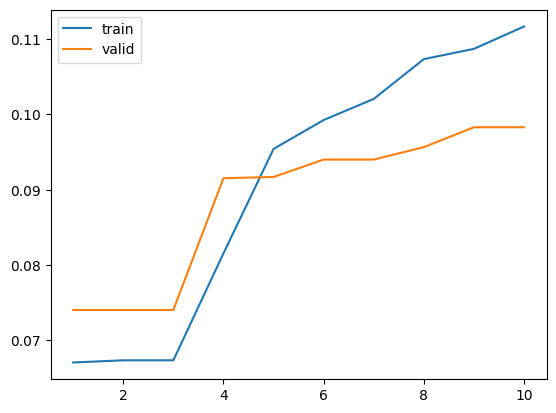

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

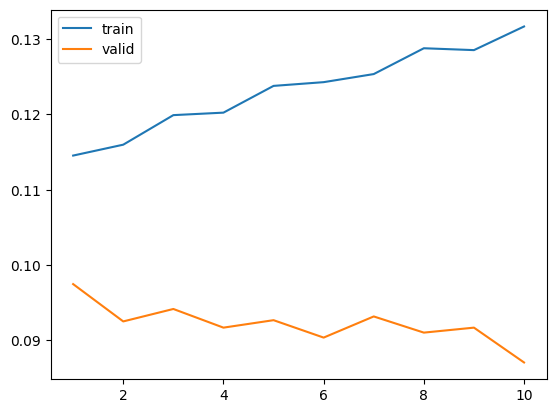

In [169]:
# Entrenamiento
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

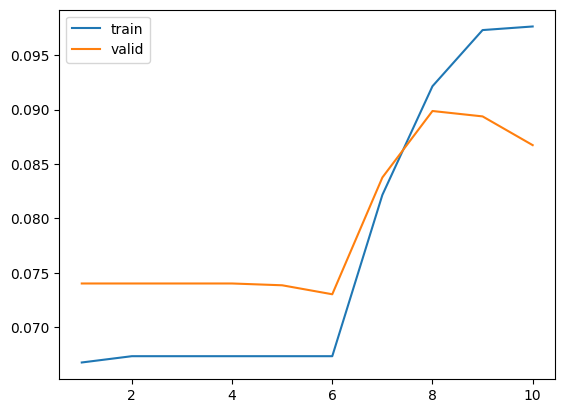

In [173]:
# Entrenamiento
epoch_count = range(1, len(hist3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [174]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [175]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [176]:
model_response("the universe")

1/1 [==============================] - 0s 22ms/step


'the universe of'

In [187]:
model_response("the time")

1/1 [==============================] - 0s 21ms/step


'the time of'

In [199]:
model_response("time far")

1/1 [==============================] - 0s 25ms/step


'time far not'

### 6 - Generación de secuencias nuevas

In [201]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [204]:
input_text='the time'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 23ms/step


'the time of '

In [205]:
input_text='universe'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 22ms/step


'universe  '

### 7 - Conclusiones
El modelo entrenado no logra realizar predicciones adecuadas, los resultados y las respuestas resultan vacias y no aporta a la continuacion del texto ingresado. Se trató de implementar variaciones en los modelos de entranamiento pero ningun logró un buen resultado.

Para este ejercicio se usaron embeddings personalizados para entrenar los distintos modelos planteados, es posible que se requieran un texto mas claro y extenso para entrenar los modelos y así poder tener mejores inferencias y mas vocabularios disponibles, combinaciónes de palabras u oraciones, etc.